### Notebook 3: Network Analysis(`03_network_analysis.ipynb`)

- [x] Create network graph object from parent-child relationships
- [x] Calculate centrality measures (PageRank, betweeness, degree, katz)
- [0] Identify "bridge varieties" connecting breeding lines (decided to not be the most actionable)
- [0] **[STRETCH]** Add PCA analysis of trait relationships (maybe more appropriate in 04)

In [1]:
# import
import sqlite3
import pandas as pd
import numpy as np
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pyvis.network import Network
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from collections import defaultdict


### **parent child relationships extracted using proprietary algorithm**

not shared here 

In [2]:
# read in db
conn = sqlite3.connect('daylilies.db')
parent_child_df = pd.read_sql_query("SELECT * FROM parent_child_relationships", conn)
conn.close()

In [3]:
# basic info
print("parent child shape:", parent_child_df.shape)
display(parent_child_df.head())

parent child shape: (138352, 2)


,source,target
0,Clark Gable,Fairest Gwendol
1,Striped Chameleon,Margaret Gellatly Memorial
2,Tequila and Lime,Margaret Gellatly Memorial
3,Neutron Star,Parallax Effect
4,Aqua Tech,Parallax Effect


In [4]:
# NetworkX graph from parent-child relationships
G = nx.DiGraph()  # Directed graph since parent->child relationships are directional
G.add_edges_from(parent_child_df[['source', 'target']].values)

# Basic network statistics
print("\nNetwork Statistics:")
print(f"Number of nodes (varieties): {G.number_of_nodes()}")
print(f"Number of edges (parent-child relationships): {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.6f}")


Network Statistics:
Number of nodes (varieties): 76449
Number of edges (parent-child relationships): 138352
Network density: 0.000024


In [5]:
# dist of in-degrees (number of parents per variety)
in_degrees = dict(G.in_degree())
in_degree_dist = pd.Series(in_degrees).value_counts().sort_index()

print("# par | # vars")
print(in_degree_dist)


# par | # vars
0      6857
1     16391
2     42155
3      7723
4      2467
5       630
6       162
7        40
8        14
9         6
10        1
11        1
12        1
13        1
Name: count, dtype: int64


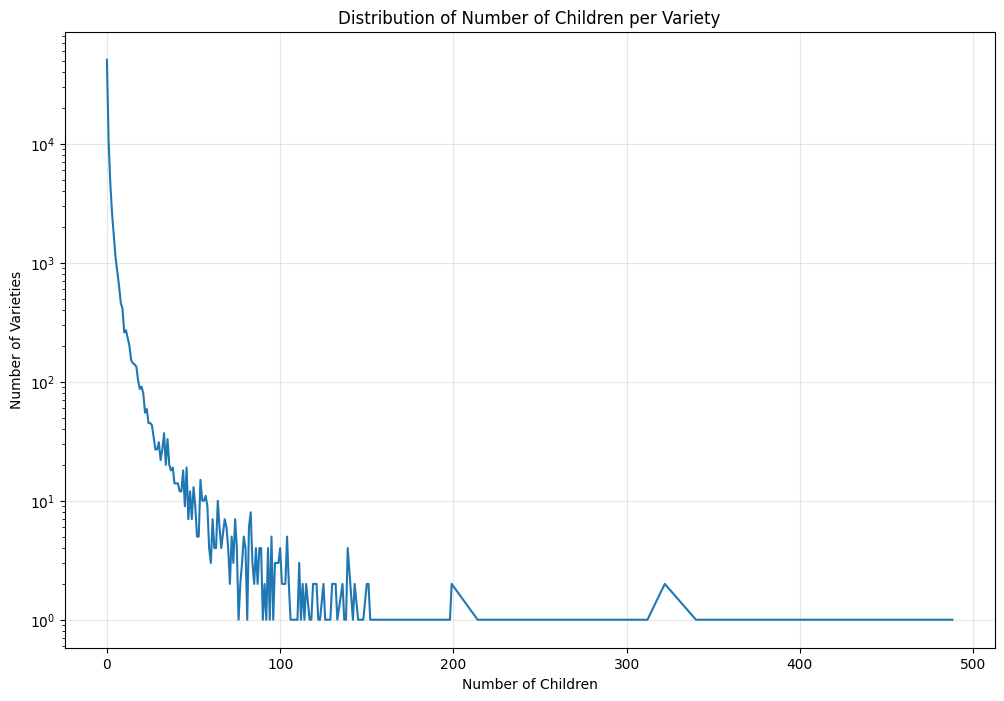

In [6]:
# dist of out-degrees (number of children per variety)
out_degrees = dict(G.out_degree())
out_degree_dist = pd.Series(out_degrees).value_counts().sort_index()

plt.figure(figsize=(12, 8))
plt.plot(out_degree_dist.index, out_degree_dist.values)
plt.xlabel('Number of Children')
plt.ylabel('Number of Varieties')
plt.title('Distribution of Number of Children per Variety')
plt.yscale('log')  # Log scale for better visualization
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# most used parents
top_parents = pd.Series(out_degrees).sort_values(ascending=False).head(10)
print("\nMost Prolific Parents:")
print(top_parents)


Most Prolific Parents:
Ed Brown                 488
Ida's Magic              454
Rose F. Kennedy          420
Lavender Blue Baby       373
J.T. Davis               359
Wedding Band             353
Strawberry Candy         340
Barbara Mitchell         322
Admiral's Braid          322
Dance Ballerina Dance    312
dtype: int64


### Centrality Measures

In [8]:
# Calculate centrality measures
print("Calculating centrality measures...")

# Degree Centrality (in and out)
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)

# PageRank
pagerank_scores = nx.pagerank(G, alpha=0.85)

# Katz Centrality
try:
    katz_centrality = nx.katz_centrality(G, alpha=0.1)
    print("Katz centrality calculated with alpha=0.1")
except:
    # if Katz fails due to convergence issues try a smaller alpha
    try:
        katz_centrality = nx.katz_centrality(G, alpha=0.01)
        print("Katz centrality calculated with alpha=0.01")
    except:
        print("Katz centrality calculation failed")
        katz_centrality = {}


Calculating centrality measures...
Katz centrality calculated with alpha=0.1


In [9]:
# Betweenness Centrality using igraph
print("Calculating betweenness centrality using igraph...")
start_time = time.time()

# NetworkX graph to igraph
# node map converts networkx named nodes to numeric indices for igraph
node_map = {node: idx for idx, node in enumerate(G.nodes())}

# reverse converts numeric indices back to original node names
reverse_map = {idx: node for node, idx in node_map.items()}

# edges are numeric tuples for igraph
edges = [(node_map[u], node_map[v]) for u, v in G.edges()]

# Create igraph Graph
ig_graph = ig.Graph(
    n=len(G.nodes()),
    edges=edges,
    directed=G.is_directed()
)

# Calculate betweenness with igraph
betweenness = ig_graph.betweenness(directed=True)

# Convert back to dictionary with original node names
betweenness_centrality = {
    reverse_map[idx]: score for idx, score in enumerate(betweenness)
}

end_time = time.time()
print(f"Betweenness calculation took {end_time - start_time:.2f} seconds")

Calculating betweenness centrality using igraph...
Betweenness calculation took 0.26 seconds


In [10]:
# df with all centrality measures
centrality_df = pd.DataFrame({
    'Variety': list(G.nodes()),
    'In_Degree_Centrality': [in_degree_centrality[node] for node in G.nodes()],
    'Out_Degree_Centrality': [out_degree_centrality[node] for node in G.nodes()],
    'PageRank': [pagerank_scores[node] for node in G.nodes()],
    'Katz_Centrality': [katz_centrality.get(node, 0) for node in G.nodes()],
    'Betweenness_Centrality': [betweenness_centrality[node] for node in G.nodes()]
})

In [11]:
# top varieties by different metrics
print("\nTop Varieties by Different Centrality Measures:")
metrics = ['PageRank', 'In_Degree_Centrality', 'Out_Degree_Centrality', 
          'Katz_Centrality', 'Betweenness_Centrality']

for metric in metrics:
    print(f"\nTop 10 varieties by {metric}:")
    # Sort the df for each metric
    top_10 = centrality_df.sort_values(by=metric, ascending=False)[['Variety', metric]].head(10)
    display(top_10)




Top Varieties by Different Centrality Measures:

Top 10 varieties by PageRank:


,Variety,PageRank
47803,Donald Spohn,0.000068
21656,San Francisco Sunday,0.000061
25080,Barely There,0.000061
33342,Red Foam,0.000061
26508,Carr Street Flower Factory,0.000059
49334,Hush Your Mouth,0.000058
23732,Bride of Bond,0.000056
22830,Pink Obsession,0.000055
63697,Sugar Sand Beach,0.000054
12687,Blue and Velvet,0.000053



Top 10 varieties by In_Degree_Centrality:


,Variety,In_Degree_Centrality
66786,Upward Call,0.000170
75582,Carefree Heart,0.000157
337,Volcanic Eruption,0.000144
26744,Callithumpian Parade,0.000131
23460,Purple Parachute,0.000118
30642,Nita Leland,0.000118
59919,Acapulco Night,0.000118
23431,Pure Hearts,0.000118
1181,Ulysses Butterfly,0.000118
19178,Tribute to Keith Melanyzer Esq,0.000118



Top 10 varieties by Out_Degree_Centrality:


,Variety,Out_Degree_Centrality
1328,Ed Brown,0.006383
5469,Ida's Magic,0.005939
101,Rose F. Kennedy,0.005494
184,Lavender Blue Baby,0.004879
25,J.T. Davis,0.004696
848,Wedding Band,0.004618
5577,Strawberry Candy,0.004447
1135,Barbara Mitchell,0.004212
651,Admiral's Braid,0.004212
1775,Dance Ballerina Dance,0.004081



Top 10 varieties by Katz_Centrality:


,Variety,Katz_Centrality
66786,Upward Call,0.007115
337,Volcanic Eruption,0.007019
75582,Carefree Heart,0.006704
26744,Callithumpian Parade,0.006533
23431,Pure Hearts,0.006465
30642,Nita Leland,0.006439
1181,Ulysses Butterfly,0.006057
19178,Tribute to Keith Melanyzer Esq,0.006012
23460,Purple Parachute,0.005990
48133,Divine Majesty,0.005968



Top 10 varieties by Betweenness_Centrality:


,Variety,Betweenness_Centrality
992,Druid's Chant,214669.518391
54339,Porcelain Pleasure,209044.972334
28581,Sari,205064.120786
848,Wedding Band,200671.346976
51778,White Illusion,194042.972334
30419,Panache,189462.708695
55559,Elizabeth Anne Hudson,185261.303139
58132,Persian Palace,181605.995786
651,Admiral's Braid,172890.098979
5469,Ida's Magic,165261.572424


In [12]:
# summary statistics for each measure
print("\nSummary Statistics for Each Centrality Measure:")
display(centrality_df[metrics].describe())


Summary Statistics for Each Centrality Measure:


,PageRank,In_Degree_Centrality,Out_Degree_Centrality,Katz_Centrality,Betweenness_Centrality
count,76449.000000,76449.000000,76449.000000,76449.000000,76449.000000
mean,0.000013,0.000024,0.000024,0.003600,247.831195
std,0.000005,0.000012,0.000114,0.000344,3660.536408
min,0.000010,0.000000,0.000000,0.002967,0.000000
25%,0.000010,0.000013,0.000000,0.003335,0.000000
50%,0.000011,0.000026,0.000000,0.003633,0.000000
75%,0.000014,0.000026,0.000013,0.003724,0.000000
max,0.000068,0.000170,0.006383,0.007115,214669.518391


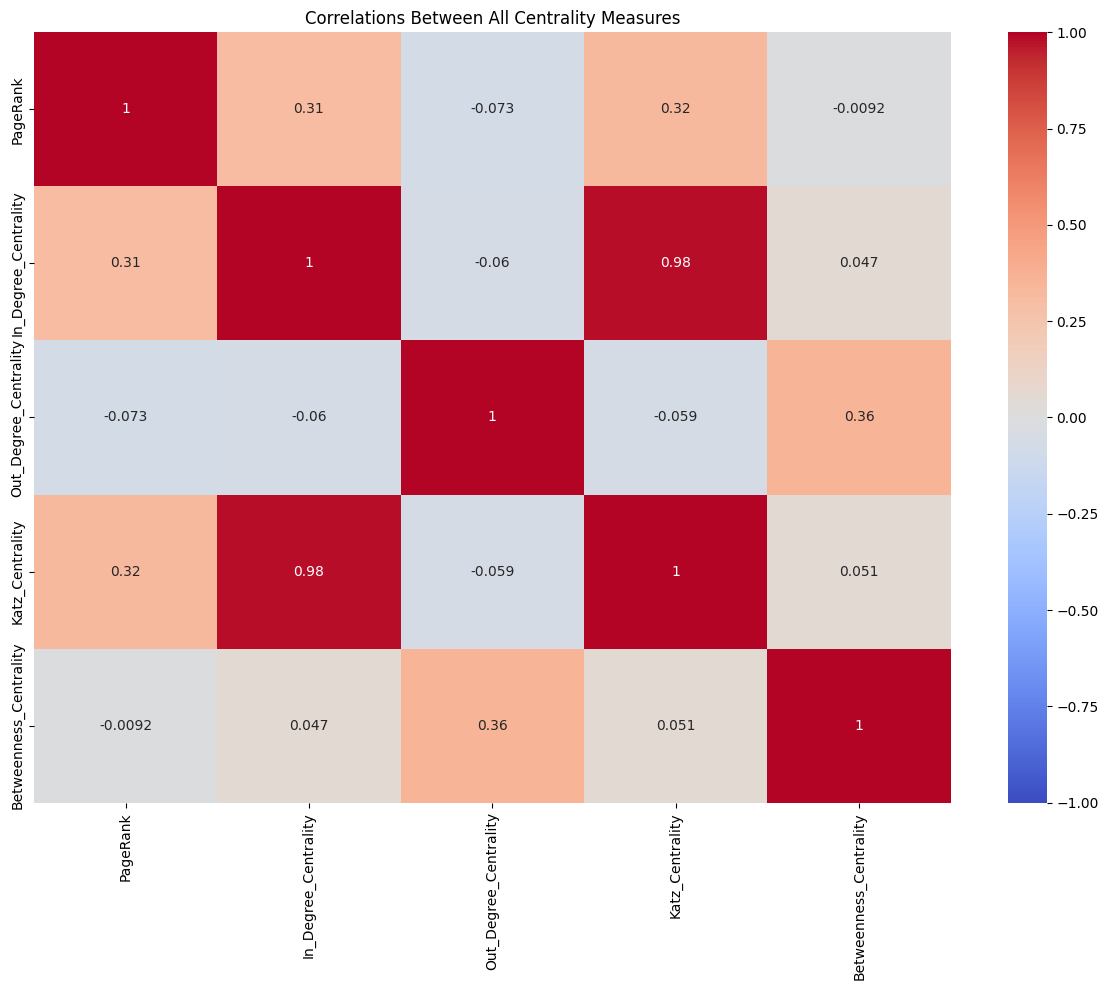

In [13]:
# correlation matrix including betweenness
correlation_matrix = centrality_df[metrics].corr()

# Plot updated correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlations Between All Centrality Measures')
plt.tight_layout()
plt.show()

### Breeding Impact

In [ ]:
def calculate_direct_breeding_metrics(G):
    """
    Calculate immediate breeding impact metrics for each variety in the graph.
    
    Args:
        G: NetworkX directed graph representing parent-child breeding relationships
    
    Returns:
        dict: Dictionary mapping variety names to their out-degree (number of 
              direct offspring/children they produced)
    """
    out_degrees = dict(G.out_degree())
    return out_degrees

def calculate_descendant_counts(G):
    """
    Calculate total descendants for each variety across all generations.
    
    Args:
        G: NetworkX directed graph representing parent-child breeding relationships
    
    Returns:
        dict: Dictionary mapping variety names to sets of all their descendants
              (offspring across all generations, not just direct children)
    """
    descendants = {}
    for node in G.nodes():
        descendants[node] = nx.descendants(G, node)
    return descendants

def calculate_generation_impact(out_degrees, descendants):
    """
    Calculate average generational impact (breeding efficiency) for each variety.
    
    Args:
        out_degrees: Dict mapping variety names to their direct offspring count
        descendants: Dict mapping variety names to sets of all descendants
    
    Returns:
        dict: Dictionary mapping variety names to their average generational impact
              (total descendants divided by direct children, representing breeding efficiency)
    """
    avg_impacts = {}
    for node in descendants.keys():
        direct_children = out_degrees.get(node, 0)
        total_descendants = len(descendants[node])
        
        if direct_children > 0:
            avg_impacts[node] = total_descendants / direct_children
        else:
            avg_impacts[node] = 0
    
    return avg_impacts

def calculate_descendant_success_rates(descendants, out_degrees):
    """
    Calculate what percentage of descendants became successful parents themselves.
    
    Args:
        descendants: Dict mapping variety names to sets of all their descendants
        out_degrees: Dict mapping variety names to their direct offspring count
    
    Returns:
        dict: Dictionary mapping variety names to success rates (0.0-1.0) representing
              the proportion of their descendants that became parents themselves
    """
    success_rates = {}
    
    for node, desc_set in descendants.items():
        if desc_set:
            # Count descendants that became parents themselves
            successful_descendants = sum(1 for desc in desc_set 
                                       if out_degrees.get(desc, 0) > 0)
            success_rates[node] = successful_descendants / len(desc_set)
        else:
            success_rates[node] = 0
    
    return success_rates

def create_breeding_metrics_dataframe(G, out_degrees, descendants, avg_impacts, success_rates):
    """
    Combine all breeding metrics into a single comprehensive DataFrame.
    
    Args:
        G: NetworkX directed graph representing parent-child relationships
        out_degrees: Dict mapping variety names to direct offspring counts
        descendants: Dict mapping variety names to sets of all descendants
        avg_impacts: Dict mapping variety names to average generational impact scores
        success_rates: Dict mapping variety names to descendant success rates
    
    Returns:
        pandas.DataFrame: DataFrame with all breeding metrics, sorted by total descendants
                         (columns: Variety, Direct_Children, Total_Descendants, 
                          Avg_Generation_Impact, Descendant_Success_Rate)
    """
    breeding_metrics = pd.DataFrame({
        'Variety': list(G.nodes()),
        'Direct_Children': [out_degrees.get(node, 0) for node in G.nodes()],
        'Total_Descendants': [len(descendants[node]) for node in G.nodes()],
        'Avg_Generation_Impact': [avg_impacts[node] for node in G.nodes()],
        'Descendant_Success_Rate': [success_rates[node] for node in G.nodes()]
    })
    
    return breeding_metrics.sort_values('Total_Descendants', ascending=False)

def analyze_breeding_impact(G):
    """
    Main function that orchestrates the complete breeding impact analysis.
    
    Args:
        G: NetworkX directed graph representing parent-child breeding relationships
    
    Returns:
        pandas.DataFrame: Comprehensive breeding metrics DataFrame with all calculated
                         metrics (direct children, total descendants, generation impact,
                         and descendant success rates) sorted by total descendants
    """
    print("Calculating direct breeding metrics...")
    out_degrees = calculate_direct_breeding_metrics(G)
    
    print("Finding all descendants...")
    descendants = calculate_descendant_counts(G)
    
    print("Calculating generation impact...")
    avg_impacts = calculate_generation_impact(out_degrees, descendants)
    
    print("Calculating descendant success rates...")
    success_rates = calculate_descendant_success_rates(descendants, out_degrees)
    
    print("Creating final metrics DataFrame...")
    breeding_metrics = create_breeding_metrics_dataframe(
        G, out_degrees, descendants, avg_impacts, success_rates
    )
    
    return breeding_metrics

print("Analyzing breeding impact metrics...")
breeding_metrics = analyze_breeding_impact(G)

# Display results
print("\nTop Breeding Varieties by Total Impact:")
display(breeding_metrics.head(20))

Analyzing breeding impact metrics...
Calculating direct breeding metrics...
Finding all descendants...
Calculating generation impact...
Calculating descendant success rates...
Creating final metrics DataFrame...

Top Breeding Varieties by Total Impact:


,Variety,Direct_Children,Total_Descendants,Avg_Generation_Impact,Descendant_Success_Rate
43296,Frances Fay,266,32839,123.454887,0.266969
52361,Betty Rice,21,30844,1468.761905,0.271819
50665,Crestwood Ann,118,30707,260.228814,0.270981
55799,Dorcas,105,30584,291.276190,0.267983
50111,Superfine,54,29693,549.870370,0.265719
58075,Evelyn Claar,50,25608,512.160000,0.262535
57132,Oriana,7,24797,3542.428571,0.265556
50585,Kings Cloak,83,23952,288.578313,0.265448
52362,White Jade,23,23841,1036.565217,0.260098
49925,Satin Glass,198,23617,119.277778,0.260194


In [15]:
# get parent-child df /+ var name and year of introduction
conn = sqlite3.connect('daylilies.db')
daylilies_df = pd.read_sql_query("SELECT name, year FROM daylilies", conn)
conn.close()

# Rename the year column to introduction_year for clarity
daylilies_df = daylilies_df.rename(columns={'year': 'introduction_year'})

In [ ]:
# temporal components
def add_temporal_metrics(breeding_metrics, daylilies_df):
    """
    Add temporal analysis to existing breeding metrics DataFrame.
    
    Args:
        breeding_metrics: pandas DataFrame with breeding impact metrics
        daylilies_df: pandas DataFrame with variety data including introduction_year column
    
    Returns:
        pandas.DataFrame: Enhanced breeding metrics with added temporal columns
                         (Introduction_Year, Breeding_Span, Yearly_Impact)
    """
    # Create year lookup
    year_lookup = daylilies_df.set_index('name')['introduction_year'].to_dict()
    max_year = daylilies_df['introduction_year'].max()
    
    # Add introduction years
    breeding_metrics['Introduction_Year'] = breeding_metrics['Variety'].map(year_lookup)
    
    # Calculate breeding span and yearly impact
    breeding_metrics['Breeding_Span'] = max_year - breeding_metrics['Introduction_Year']
    breeding_metrics['Yearly_Impact'] = (
        breeding_metrics['Total_Descendants'] / breeding_metrics['Breeding_Span']
    ).fillna(0)
    
    return breeding_metrics

# Extend existing results instead of recalculating
enhanced_metrics = add_temporal_metrics(breeding_metrics, daylilies_df)

display(enhanced_metrics.head(20))

,Variety,Direct_Children,Total_Descendants,Avg_Generation_Impact,Descendant_Success_Rate,Introduction_Year,Breeding_Span,Yearly_Impact
43296,Frances Fay,266,32839,123.454887,0.266969,1957.0,67.0,490.134328
52361,Betty Rice,21,30844,1468.761905,0.271819,1956.0,68.0,453.588235
50665,Crestwood Ann,118,30707,260.228814,0.270981,1961.0,63.0,487.412698
55799,Dorcas,105,30584,291.276190,0.267983,1958.0,66.0,463.393939
50111,Superfine,54,29693,549.870370,0.265719,1960.0,64.0,463.953125
58075,Evelyn Claar,50,25608,512.160000,0.262535,1949.0,75.0,341.440000
57132,Oriana,7,24797,3542.428571,0.265556,1966.0,58.0,427.534483
50585,Kings Cloak,83,23952,288.578313,0.265448,1969.0,55.0,435.490909
52362,White Jade,23,23841,1036.565217,0.260098,1954.0,70.0,340.585714
49925,Satin Glass,198,23617,119.277778,0.260194,1960.0,64.0,369.015625


In [17]:
# Merge enhanced metrics with centrality measures
final_metrics = enhanced_metrics.merge(
    centrality_df, 
    on='Variety', 
    how='left'  # all varieties from enhanced_metrics, add centralities
)

# Display the head to see the combined result
print("Combined metrics preview:")
print(f"Shape: {final_metrics.shape}")
print("\nColumns:", final_metrics.columns.tolist())
print("\nFirst few rows:")
print(final_metrics.head())


# Export the combined network influence metrics
final_metrics.to_csv('data/network_influence_metrics.csv', index=False)
print(f"\nCombined network influence metrics exported to: data/network_influence_metrics.csv")
print(f"Total varieties: {len(final_metrics)}")
print(f"Total columns: {len(final_metrics.columns)}")

Combined metrics preview:
Shape: (76449, 13)

Columns: ['Variety', 'Direct_Children', 'Total_Descendants', 'Avg_Generation_Impact', 'Descendant_Success_Rate', 'Introduction_Year', 'Breeding_Span', 'Yearly_Impact', 'In_Degree_Centrality', 'Out_Degree_Centrality', 'PageRank', 'Katz_Centrality', 'Betweenness_Centrality']

First few rows:
         Variety  Direct_Children  Total_Descendants  Avg_Generation_Impact  \
0    Frances Fay              266              32839             123.454887   
1     Betty Rice               21              30844            1468.761905   
2  Crestwood Ann              118              30707             260.228814   
3         Dorcas              105              30584             291.276190   
4      Superfine               54              29693             549.870370   

   Descendant_Success_Rate  Introduction_Year  Breeding_Span  Yearly_Impact  \
0                 0.266969             1957.0           67.0     490.134328   
1                 0.271819    

In [18]:
# Save network influence metrics to SQLite database
conn = sqlite3.connect('daylilies.db')

# declare table name
table_name = 'network_influence_metrics'

# Save to database
try:
    final_metrics.to_sql(table_name, conn, if_exists='replace', index=False)
    print(f"Successfully saved network influence metrics to '{table_name}' table in database")
    
    # First few rows
    print("\nFirst few rows of the new table:")
    display(pd.read_sql(f"SELECT * FROM {table_name} LIMIT 5", conn))

except Exception as e:
    print(f"Error saving to database: {e}")

finally:
    conn.close()

Successfully saved network influence metrics to 'network_influence_metrics' table in database

First few rows of the new table:


,Variety,Direct_Children,Total_Descendants,Avg_Generation_Impact,Descendant_Success_Rate,Introduction_Year,Breeding_Span,Yearly_Impact,In_Degree_Centrality,Out_Degree_Centrality,PageRank,Katz_Centrality,Betweenness_Centrality
0,Frances Fay,266,32839,123.454887,0.266969,1957.0,67.0,490.134328,0.000000,0.003479,0.00001,0.002967,0.000000
1,Betty Rice,21,30844,1468.761905,0.271819,1956.0,68.0,453.588235,0.000000,0.000275,0.00001,0.002967,0.000000
2,Crestwood Ann,118,30707,260.228814,0.270981,1961.0,63.0,487.412698,0.000013,0.001544,0.00001,0.003263,22495.260201
3,Dorcas,105,30584,291.276190,0.267983,1958.0,66.0,463.393939,0.000000,0.001373,0.00001,0.002967,0.000000
4,Superfine,54,29693,549.870370,0.265719,1960.0,64.0,463.953125,0.000013,0.000706,0.00001,0.003263,9789.987521


# Network Analysis Summary

## Key Findings

### Historical Breeding Influence (1950s-1960s Golden Age)
- **Peak Period**: Varieties introduced in 1950s-1960s show the highest breeding influence
- **Top Performers**: 
  1. Frances Fay (1957) -  32,478 total descendants
  2. Crestwood (1961) -  30,914 total descendants
  3. Dorcas (1958) - 30,505 total descendants


## Network Metrics Analysis

### Direct vs. Multi-generational Impact
- High direct children count doesn't always correlate with long-term influence
- Example: Wedding Band (1987) - 353 direct children vs Frances Fay (1957) - 266 children but higher total impact


## Implications for Breeding Value Analysis

### Key Considerations for later analysis
1. Focus trait analysis on identified high-influence varieties
2. Consider both short-term (direct) and long-term (multi-generational) breeding success
3. Examine trait patterns from the 1950s-1960s "golden age" of breeding

### Notable Patterns
- Sustained breeding impact requires both:
  - Quality of offspring (success rate)
  - Quantity of descendants (total impact)
- Most influential varieties maintain impact over 50+ year spans

## Network Analysis Conclusions
- Historical varieties show higher contribution despite fewer introductions
- Modern era shows quantity over influence in breeding patterns
- Success in breeding appears to require balance of direct offspring quality and long-term genetic contribution
